In [3]:
from matplotlib import pyplot as plt
import os
import numpy as np
import segyio
def load_sgy(filename):
    with segyio.open(filename, ignore_geometry=True) as segyfile:
        data = np.array(segyfile.trace.raw[:])
    return data

path0 = 'TestData/71910_1.9' # 读取文件夹下的所有文件
files = os.listdir(path0)
files.sort()
data00 = load_sgy(os.path.join(path0, files[0])) # 读取第一个文件
data01 = load_sgy(os.path.join(path0, files[1])) # 读取第二个文件
print(data00.shape, data01.shape) # 查看两个文件的形状
data0 = np.hstack((data00, data01)) # 拼接两个文件

(3904, 2000) (3904, 2000)


## 地震记录波形图

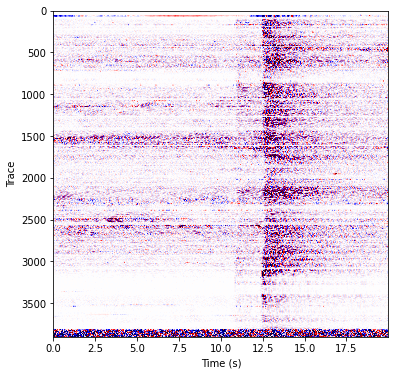

In [6]:
plt.figure(figsize=(6, 6))
plt.imshow(data0, aspect='auto', cmap='seismic',clim = [-1000, 1000])
#plt.colorbar(label = 'strain rate (nano s^-1)')
plt.xlabel('Time (s)')
plt.ylabel('Trace')
plt.xticks(np.arange(0, data0.shape[1], 500), np.arange(0, data0.shape[1], 500)/200)
plt.show()

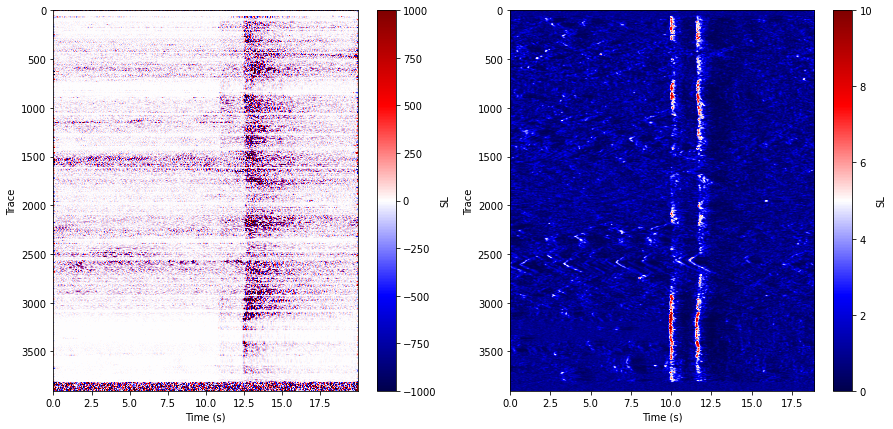

In [8]:
from dasflow.preprocess import data_filter, data_SL
data_f = data_filter(data0, 1, 10) # 1-10Hz 带通滤波 实际过程中最好使用短时傅里叶变换确定信号主频
data_sl = data_SL(data_f, 20, 200, pad=False) # 长短窗能量比法 实际过程中建议测试不同短窗大小，以使得预处理后的地震P/S波有明显的边缘
plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)     
plt.imshow(data_f, aspect='auto', cmap='seismic',clim = [-1000, 1000])
plt.colorbar(label = 'SL')
plt.xlabel('Time (s)')  
plt.ylabel('Trace')
plt.xticks(np.arange(0, data_sl.shape[1], 500), np.arange(0, data_sl.shape[1], 500)/200)

plt.subplot(1, 2, 2)
plt.imshow(data_sl, aspect='auto', cmap='seismic',clim = [0, 10])
plt.colorbar(label = 'SL')
plt.xlabel('Time (s)')  
plt.ylabel('Trace')
plt.xticks(np.arange(0, data_sl.shape[1], 500), np.arange(0, data_sl.shape[1], 500)/200)
plt.show()

## 神经网络检测

In [16]:
# 将连续数据分割为帧
from dasflow.preprocess import auto_split
datas = auto_split(data_sl, hwin=512, wwin=512, overlap=0.25)
datas.shape

(9, 9, 512, 512)

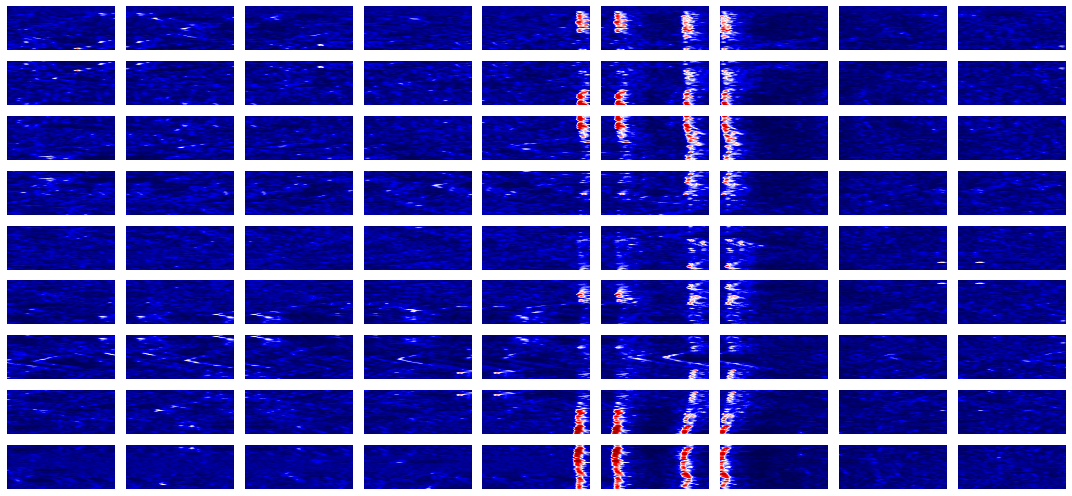

In [17]:
# 展示分割后的数据块，可见第5、6、7列包含有效的地震事件
plt.figure(figsize=(15, 7))
for i in range(9):
    for j in range(9):
        plt.subplot(9, 9, i*9+j+1)
        plt.imshow(datas[i, j], aspect='auto', cmap='seismic',clim = [0, 10])
        plt.axis('off')
plt.tight_layout()
plt.show()

In [13]:
from dasflow.model import Mini
import torch
model = Mini() # 使用最基础的网络结构进行检测
model.load_state_dict(torch.load('dasflow/model_all.pth')) # 使用预训练好的模型权重进行检测

<All keys matched successfully>

In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.eval().to(device)
outputs = model(torch.tensor(datas).float().to(device).view(-1, 1, 512, 512) / 5) # 推理 ，这里的/5是因为在网络训练时做了同样的操作
outputs = outputs.cpu().detach().numpy()
outputs.shape

(81, 2)

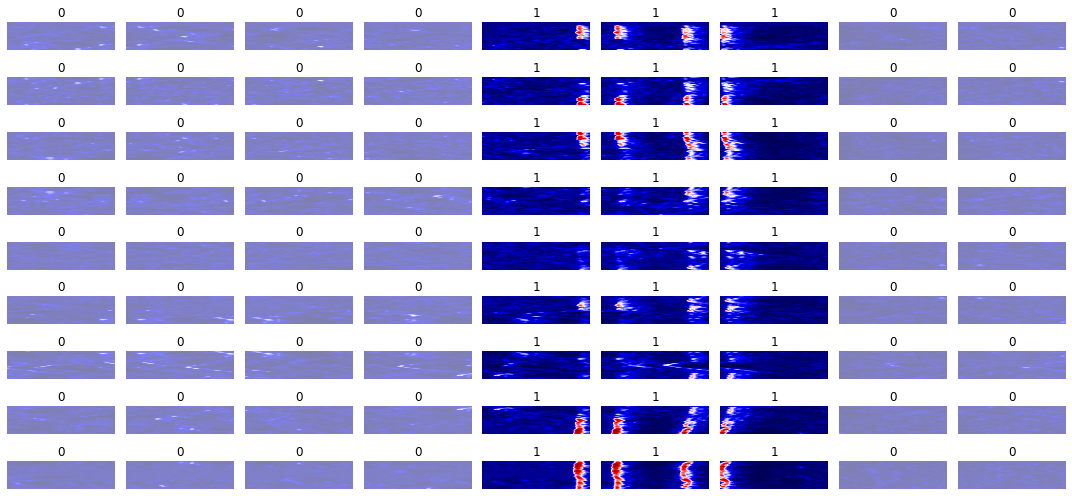

In [15]:
# 展示检出地震记录的记录块
output_class = np.argmax(outputs, axis=1)
plt.figure(figsize=(15, 7))
for i in range(9):
    for j in range(9):
        plt.subplot(9, 9, i*9+j+1)
        plt.imshow(datas[i, j], aspect='auto', cmap='seismic',clim = [0, 10],alpha=output_class[i*9+j] * 0.5 + 0.5)
        plt.title(f'{output_class[i*9+j]}') 
        plt.axis('off')
plt.tight_layout()
plt.show()

## 模板匹配检测

In [18]:
import numpy as np
data_17 = np.load('TestData/das_0017.npy')
data_22 = np.load('TestData/das_0022.npy')

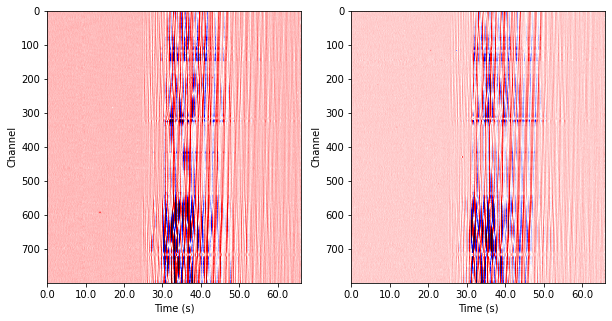

In [23]:
from matplotlib import pyplot as plt
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.imshow(data_22.T[:,1200:-1200], cmap='seismic', aspect='auto',clim = (-300,300))
plt.xticks(np.arange(0,7000,1000),np.arange(0,7000,1000)*0.01)
plt.xlabel('Time (s)')
plt.ylabel('Channel')


plt.subplot(122)
plt.imshow(data_17.T[:,1200:-1200], cmap='seismic', aspect='auto',clim = (-300,300))
plt.xticks(np.arange(0,7000,1000),np.arange(0,7000,1000)*0.01)
plt.xlabel('Time (s)')
plt.ylabel('Channel')
plt.show()

Text(0, 0.5, 'Channel')

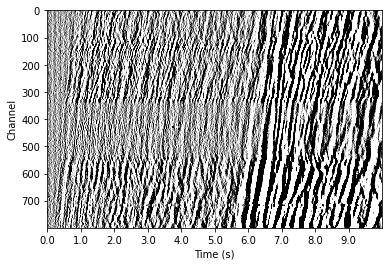

In [21]:
tmp = data_17.T[:,1200+2500:4700]   
plt.imshow(tmp, cmap='gray', aspect='auto',clim = (-100,100))
plt.xticks(np.arange(0,1000,100),np.arange(0,1000,100)*0.01)
plt.xlabel('Time (s)')
plt.ylabel('Channel')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


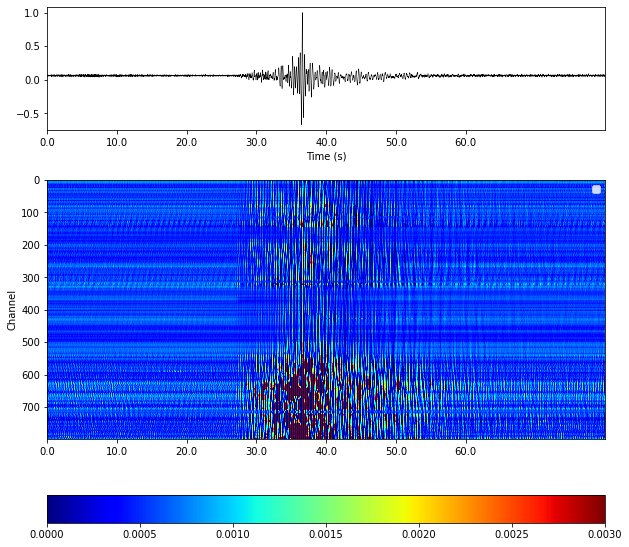

In [60]:
from dasflow import tma
data = data_22.T.copy()
corr = tma(data,tmp, step=1,device='cpu',moves=[],is_sum=False,batch_size=-1,half=False,save_memory=False)
cc = corr[0].detach().numpy().mean(axis=0)
cc = cc/np.max(cc)

# calculate the cross-correlation between the template and the image
from matplotlib import gridspec
gs = gridspec.GridSpec(2, 1, height_ratios=[1, 3])
plt.figure(figsize=(10,10))
plt.subplot(gs[0])
plt.plot(cc, color='k', label='CC',linewidth=0.5)
plt.xticks(np.arange(0,7000,1000),np.arange(0,7000,1000)*0.01)
plt.xlabel('Time (s)')
plt.subplot(gs[1],sharex=plt.gca())
plt.imshow(corr[0], cmap='jet', aspect='auto',clim = (0,0.003))
# 放在下方
plt.colorbar(location='bottom')
plt.ylabel('Channel')
plt.legend()
plt.show()